# Movielens
---
Esta base de datos contiene información sobre películas y ratings de distintos usuarios.
Responde a las siguientes preguntas

<div class="panel panel-danger">
    <div class='panel-heading'>
    <h4>Antes de empezar</h4>
    </div>
    <div class='panel-body'>
    <p>Para poder ejecutar queries a la base de datos, necesitamos tener instalado antes el paquete [ipython-sql](https://github.com/catherinedevlin/ipython-sql).
    
    <p>Este paquete nos permite escribir las queries sql en las celdas del notebook y visualizar el resultado como tablas html renderizadas
    <p>Ejecuta `!pip install ipython-sql` si es la primera vez que usas este notebook
    </div>
</div>

In [1]:
!pip install ipython-sql

  Running setup.py bdist_wheel for prettytable ... done
  Stored in directory: /Users/justoherreroamoros/Library/Caches/pip/wheels/b6/90/7b/1c22b89217d0eba6d5f406e562365ebee804f0d4595b2bdbcd
Successfully built prettytable


**Cargamos la base de datos ** 

In [1]:
%load_ext sql
%sql sqlite:///data/movies/movielens.sqlite
%sql SELECT name FROM sqlite_master WHERE type='table'

Done.


name
ratings
links
tags
movies


Antes de empezar, recuerda que para ejecutar una query sql en las celdas de los notebooks, debes empezar la celda por `%%sql`. Por ejemplo...

In [2]:
%%sql

SELECT count(*) as num_rows
FROM movies

Done.


num_rows
9125


Recuerda que también puedes realizar queries a la base de datos usango `pandas` y `sqlite3`

** Preparación del entorno **

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3

conn = sqlite3.connect('data/movies/movielens.sqlite')

---
<div class="panel panel-success">
    <div class='panel-heading'>
    <h4>Empecemos</h4>
    </div>
    <div class='panel-body'>
    <p> Responde a las siguientes preguntas de la base de datos
    </div>
</div>

**1. Nombra las columnas de cada tabla en la base de datos e identifíca las *primary* y *foreign* keys **

In [4]:
%%sql 
PRAGMA table_info(movies)

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,movieId,INTEGER,0,None,0
2,title,TEXT,0,None,0
3,genres,TEXT,0,None,0


Las columnas de la tabla **movies** son:
* index
* movieId
* title
* genres

In [8]:
%%sql
PRAGMA table_info(ratings)

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,userId,INTEGER,0,None,0
2,movieId,INTEGER,0,None,0
3,rating,REAL,0,None,0
4,timestamp,TIMESTAMP,0,None,0


Las columnas de la tabla **ratings** son:
* index
* userId
* movieId
* rating
* timestamp

In [110]:
%%sql
PRAGMA table_info(links)

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,movieId,INTEGER,0,None,0
2,imdbId,INTEGER,0,None,0
3,tmdbId,REAL,0,None,0


Las columnas de la tabla **links** son:
* index
* movieId
* imdbId
* tmdbId

In [109]:
%%sql
PRAGMA table_info(tags)

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,userId,INTEGER,0,None,0
2,movieId,INTEGER,0,None,0
3,tag,TEXT,0,None,0
4,timestamp,TIMESTAMP,0,None,0


Las columnas de la tabla **movies** son:
* index
* userId
* movieId
* tag
* timestamp

Como no vemos ningún `pk = 1`, ninguna de las tablas tiene `PRIMARY KEY`. Alternativamente podemos hacer lo siguiente:

In [10]:
%%sql
SELECT sql
  FROM (
        SELECT sql sql, type type, tbl_name tbl_name, name name
          FROM sqlite_master
         UNION ALL
        SELECT sql, type, tbl_name, name
          FROM sqlite_temp_master
       )
 WHERE type != 'meta'
   AND sql NOTNULL
   AND name NOT LIKE 'sqlite_%'
 ORDER BY substr(type, 2, 1), name

Done.


sql
"CREATE TABLE ""links"" (""index"" INTEGER, ""movieId"" INTEGER, ""imdbId"" INTEGER, ""tmdbId"" REAL)"
"CREATE TABLE ""movies"" (""index"" INTEGER, ""movieId"" INTEGER, ""title"" TEXT, ""genres"" TEXT)"
"CREATE TABLE ""ratings"" (""index"" INTEGER, ""userId"" INTEGER, ""movieId"" INTEGER, ""rating"" REAL, ""timestamp"" TIMESTAMP)"
"CREATE TABLE ""tags"" (""index"" INTEGER, ""userId"" INTEGER, ""movieId"" INTEGER, ""tag"" TEXT, ""timestamp"" TIMESTAMP)"
"CREATE INDEX ""ix_links_index""ON ""links"" (""index"")"
"CREATE INDEX ""ix_movies_index""ON ""movies"" (""index"")"
"CREATE INDEX ""ix_ratings_index""ON ""ratings"" (""index"")"
"CREATE INDEX ""ix_tags_index""ON ""tags"" (""index"")"


De lo que extraemos que no hay ni `PRIMARY KEYS` ni `FOREIGN KEYS`. En cambio, si hay cuatro íncides, uno en cada tabla, llamado `index`.

**2. ¿Cómo evolucion el rating de '12 Angry Men' a lo largo de los años? Haz un gráfico de la evolución**

Como vemos a continuación, existen dos versiones de la película 12 Angry Men, una en el año **1957** y otra en el año **1997** por lo que deberemos tener en cuenta ambas a la hora de ver la evolución de las valoraciones a lo largo de los años.

In [45]:
%%sql
SELECT * FROM movies WHERE title LIKE('%12 Angry Men%')

Done.


index,movieId,title,genres
960,1203,12 Angry Men (1957),Drama
7533,77846,12 Angry Men (1997),Crime|Drama


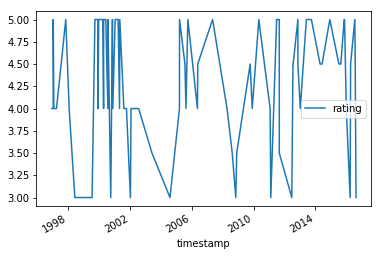

In [28]:
query = """
    SELECT rating, timestamp FROM ratings
        INNER JOIN movies 
        ON ratings.movieId = movies.movieId
    WHERE title LIKE('%12 Angry Men%')
    ORDER BY timestamp
"""
df = pd.read_sql(query, conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(df['timestamp'])
df = df.drop('timestamp', axis = 1)
df.plot()

En el gráfico anterior tenemos la evolución de la valoración de la película, donde vemos que la puntuación fluctua entre 5 y 3.

** 3. ¿Cuál es la película peor valorada de cada año? **

In [21]:
%%sql

SELECT strftime("%Y", timestamp) as 'Year',
title as 'Movie title', min(rating) as 'Worst Rating'
FROM movies INNER JOIN ratings
ON movies.movieId = ratings.movieId
GROUP BY strftime("%Y", timestamp)


Done.


Year,Movie title,Worst Rating
1995,Get Shorty (1995),3.0
1996,Toy Story (1995),1.0
1997,Toy Story (1995),1.0
1998,Lawnmower Man 2: Beyond Cyberspace (1996),1.0
1999,Toy Story (1995),1.0
2000,Grumpier Old Men (1995),1.0
2001,Tom and Huck (1995),1.0
2002,Babe (1995),1.0
2003,Seven (a.k.a. Se7en) (1995),0.5
2004,Sabrina (1995),0.5


** 4. ¿Quién es el usuario más activo y desde cuándo lleva activo? **

A continuación apararecen los 10 usuarios más activos en cuanto a valoraciones se refiere y la fecha desde la que están activos.

In [22]:
%%sql

SELECT userId, Count(userId) as 'Total ratings', 
         min(timestamp) as 'From date'
    FROM ratings
    GROUP BY userId
    ORDER BY Count(userId) DESC
    LIMIT 10

Done.


userId,Total ratings,From date
547,2391,2000-11-21 03:25:09
564,1868,2000-11-20 08:20:46
624,1735,2002-04-18 09:57:46
15,1700,2001-08-16 04:47:19
73,1610,2009-10-14 06:14:12
452,1340,2000-12-10 03:28:59
468,1291,2011-01-28 04:34:19
380,1063,2000-02-01 01:05:25
311,1019,1998-06-09 14:47:53
30,1011,1999-12-11 20:11:10


El usuario más activo es **547** con un total de **2391** valoraciones el cuál está activo desde el **21-11-2000**

** 5. ¿Cuales son sus 5 películas favorítas del año 2016? **

Las películas favoritas del usuario **547** son las siguientes:

In [29]:
%%sql

SELECT title as 'Movie title', rating as 'User rating' 
    FROM ratings
        INNER JOIN movies
        ON movies.movieId = ratings.movieId
    WHERE strftime("%Y", timestamp) = '2016' AND userId = '547'
    ORDER BY rating DESC
    LIMIT 5

Done.


Movie title,User rating
Making a Murderer (2015),5.0
The Beatles: Eight Days a Week - The Touring Years (2016),5.0
"Lust, Caution (Se, jie) (2007)",4.5
"Impossible, The (Imposible, Lo) (2012)",4.5
Ex Machina (2015),4.5


**6. Haz una gráfica de como evolucionan el número de películas que ve cada año y la nota media. **

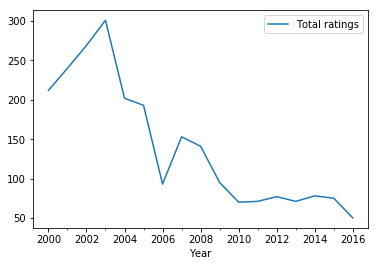

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

query = """
SELECT strftime("%Y", timestamp) as 'Year', Count(userId) as 'Total ratings' FROM ratings
WHERE userId = '547'
GROUP BY strftime("%Y", timestamp)
"""
df = pd.read_sql(query, conn)
df['Year'] = pd.to_datetime(df['Year'])
df = df.set_index(df['Year'])
df = df.drop('Year', axis = 1)
df.plot()

En el gráfico anterior, vemos como el número de valoraciones realizadas por el usuario **547** ha ido decreciendo desde el año 2000 hasta el año 2016 con un máximo en el año 2003 de 301 valoraciones y un mínimo en el año 2016 con tan solo 50.

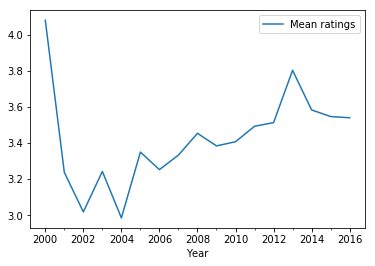

In [27]:
query = """
SELECT strftime("%Y", timestamp) as 'Year', 
        AVG(rating) as 'Mean ratings' 
    FROM ratings
    WHERE userId = '547'
    GROUP BY strftime("%Y", timestamp)
"""
df = pd.read_sql(query, conn)
df['Year'] = pd.to_datetime(df['Year'])
df = df.set_index(df['Year'])
df = df.drop('Year', axis = 1)
df.plot()

En el gráfico anterior, vemos la nota media de las valoraciones del usuario **547** realizadas por año. La valoración media más alta la encontramos el año 2000 con 4.08 puntos. Por contra, la valoración más baja la encontramos el año 2004 con una puntuación de 2.95.